In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import  fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Carga de Datasets 

In [2]:
criminalidad2 = pd.read_csv("communities.data")
names = []
with open('communities.names', 'r') as f:
    for line in f:
        if line.startswith("@attribute"):
            names.append(line.split()[1])

In [5]:
with open("communities.names", "r", errors="ignore") as f:
    lines = f.readlines()

column_names = []

for line in lines:
    if line.lower().startswith("@attribute"):
        parts = line.split()
        if len(parts) >= 2:
            col_name = parts[1]
            column_names.append(col_name)

len(column_names), column_names[:10]

(128,
 ['state',
  'county',
  'community',
  'communityname',
  'fold',
  'population',
  'householdsize',
  'racepctblack',
  'racePctWhite',
  'racePctAsian'])

### Cambiar nombres de las columnas del Dataset "communities.data" por nombres de las columnas del Dataset "communities.names"

In [6]:
attr_names = []

with open("communities.names", "r", encoding="latin1") as f:
    for line in f:
        line = line.strip()
        if line.lower().startswith("@attribute"):
            parts = line.split()
            if len(parts) >= 2:
                attr_names.append(parts[1])


if len(attr_names) != criminalidad2.shape[1]:
    print("⚠️ No coinciden los atributos. Usando nombres genéricos.")
    attr_names = [f"attr_{i}" for i in range(criminalidad2.shape[1])]

criminalidad2.columns = attr_names

### Tratar los datos normalizandolos y convirtiendolos a float

In [7]:
# Convertir ? a NaN
criminalidad2 = criminalidad2.replace("?", np.nan)

criminalidad2 = criminalidad2.apply(pd.to_numeric, errors="coerce")

null_percent = criminalidad2.isna().mean() * 100
# 2) Columnas con demasiados nulos
cols_to_drop = null_percent[null_percent > 70].index.tolist()

### Preparar las variables que necesitamos, dividiendo el data en test y en train

In [9]:
from sklearn.impute import SimpleImputer
features = [
    "PctKids2Par",
    "PctIlleg",
    "PctFam2Par",
    "racePctWhite",
    "PctYoungKids2Par",
    "PctTeen2Par",
    "racepctblack",
    "pctWInvInc",
    "pctWPubAsst",
    "FemalePctDiv",
    "TotalPctDiv",
    "PctPersOwnOccup",
    "MalePctDivorce",
    "PctPopUnderPov",
    "PctUnemployed",
    "PctHousNoPhone",
    "PctNotHSGrad",
    "PctVacantBoarded",
    "PctHousLess3BR",
    "NumIlleg"
]

target = "ViolentCrimesPerPop"

# 2. Crear dataset
df_model = criminalidad2[features + [target]].copy()
df_model = df_model.apply(pd.to_numeric, errors="coerce")

# 3. Imputar nulos
imputer = SimpleImputer(strategy="mean")
df_model[features + [target]] = imputer.fit_transform(df_model[features + [target]])

# 4. Separar X e y
X = df_model[features]
y = df_model[target]

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# 6. Escalado
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
correlations = criminalidad2.corr(numeric_only=True)[target].abs().sort_values(ascending=False)

criminalidad_filtrada2 = correlations.drop(labels=[target]).head(20).index.tolist()


In [11]:
# Separar X e y
X_final = criminalidad2.drop(columns=[target])
y_final = criminalidad2[target]


# Imputación simple
X_small = X_final.fillna(X_final.median())
y_small = y_final.fillna(y_final.median())


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [13]:
criminalidad2 = criminalidad2.apply(pd.to_numeric, errors="coerce")

### Inicio de entreno de modelos 


#### KNN

In [211]:
# MODELO KNN
knn = KNeighborsRegressor(n_neighbors=5)

# ENTRENAR
knn.fit(X_train_scaled, y_train)

# PREDECIR
pred_knn = knn.predict(X_test_scaled)

# MÉTRICAS
rmse = np.sqrt(mean_squared_error(y_test, pred_knn))
r2 = r2_score(y_test, pred_knn)

print("🔵 KNN RESULTS")
print("RMSE:", rmse)
print("R²:", r2)

🔵 KNN RESULTS
RMSE: 0.14947715058284297
R²: 0.6101022489256778


#### Arbol de decision

In [212]:
tree = DecisionTreeRegressor(max_depth=None, random_state=0)

tree.fit(X_train_scaled, y_train)

pred_tree = tree.predict(X_test_scaled)

rmse_tree = np.sqrt(mean_squared_error(y_test, pred_tree))
r2_tree = r2_score(y_test, pred_tree)

print("🟢 Decision Tree RESULTS")
print("RMSE:", rmse_tree)
print("R²:", r2_tree)

🟢 Decision Tree RESULTS
RMSE: 0.18993139508015186
R²: 0.3705016071646855


#### Bagging

In [ ]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20), 
                               n_estimators=300, # número arboles
                               max_samples = 1500) # número filas data set para entrenar cada modelo

In [ ]:
bagging_reg.fit(X_train_scaled, y_train)

In [ ]:
pred = bagging_reg.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", bagging_reg.score(X_test_scaled, y_test))

In [194]:
preds = bagging_reg.predict(X_test_scaled)  # o model.predict(X_test) según tu flujo
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.14413278570354923
R2: 0.6374844250375987


#### Random

In [ ]:
forest = RandomForestRegressor(n_estimators=300,
                             max_depth=20)

In [ ]:
forest.fit(X_train_scaled, y_train)

In [ ]:
pred = forest.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", forest.score(X_test_scaled, y_test))

In [195]:
preds = forest.predict(X_test_scaled)  # o model.predict(X_test) según tu flujo
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.1431850636962737
R2: 0.6422360776440335


#### Ada

In [ ]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)

In [ ]:
ada_reg.fit(X_train_scaled, y_train)

In [191]:
preds = ada_reg.predict(X_test_scaled)  # o model.predict(X_test) según tu flujo
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.1459405490837354
R2: 0.6283338054385086


#### Gradient

In [ ]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)

In [ ]:
gb_reg.fit(X_train_scaled, y_train)

In [193]:
preds = gb_reg.predict(X_test_scaled)  # o model.predict(X_test) según tu flujo
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.17818483015248898
R2: 0.4459581585714265


#### Regresión lineal

In [197]:
from sklearn.linear_model import LinearRegression
# Crear modelo
lin_reg = LinearRegression()

# Entrenar
lin_reg.fit(X_train_scaled, y_train)

# Predecir
y_pred_lr = lin_reg.predict(X_test_scaled)


In [198]:
# R²
r2_lr = r2_score(y_test, y_pred_lr)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("R² regresión lineal:", r2_lr)
print("RMSE regresión lineal:", rmse_lr)


R² regresión lineal: 0.6545806742143282
RMSE regresión lineal: 0.14069308787890006


#### Tras realizar diferentes entrenamientos con varios algoritmos de Machine Learning aplicados al dataset Communities & Crime, se evaluó el rendimiento de cada modelo utilizando el coeficiente R², que mide cuánta variabilidad del crimen violento es capaz de explicar el modelo. Después de comparar resultados, el modelo que mejor rendimiento ofreció fue:

   - **Regresión Lineal**
   - **R² ≈ 0.65 (65%)**

#### Este resultado indica que la regresión lineal es capaz de explicar el **65% de la variabilidad del crimen violento a partir de las variables seleccionadas**

#### Prueba del KNN

In [214]:
from scipy.stats import randint
param_dist = {
    "n_neighbors": randint(2, 30),
    "p": randint(1, 3)
}

knn_random = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring="r2",
    random_state=0,
    n_jobs=-1
)

knn_random.fit(X_train_scaled, y_train)

print("Mejores parámetros KNN (Random):", knn_random.best_params_)
print("Mejor R2:", knn_random.best_score_)

c:\Users\noeli\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros KNN (Random): {'n_neighbors': 17, 'p': 1}
Mejor R2: 0.6302237599024226


#### Prueba del Arbol 

In [215]:
param_dist = {
    "max_depth": randint(3, 40),
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 15)
}

tree_random = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=0),
    param_distributions=param_dist,
    n_iter=40,
    scoring="r2",
    cv=5,
    random_state=0,
    n_jobs=-1
)

tree_random.fit(X_train_scaled, y_train)

print("Mejores parámetros Árbol (Random):", tree_random.best_params_)
print("Mejor R2:", tree_random.best_score_)

Mejores parámetros Árbol (Random): {'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 6}
Mejor R2: 0.5409125120764384


#### Prueba del Bagging

In [205]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint, uniform

# Modelo base
base = KNeighborsRegressor()

# Distribución de parámetros
param_dist = {
    "estimator__n_neighbors": randint(2, 15),
    "n_estimators": randint(10, 150),
    "max_samples": uniform(0.4, 0.6)
}

# Modelo Bagging
bagging = BaggingRegressor(estimator=base, random_state=0)

# Random Search
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=30,             # Nº de combinaciones aleatorias
    cv=5,
    scoring='r2',
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("\nMejor R2 encontrado:", random_search.best_score_)


Mejores hiperparámetros encontrados:
{'estimator__n_neighbors': 13, 'max_samples': np.float64(0.9930243028355357), 'n_estimators': 57}

Mejor R2 encontrado: 0.6304675002506556


#### Prueba del Random Forest Regression

In [213]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir modelo base
rf = RandomForestRegressor(random_state=0)

# Definir rejilla de hiperparámetros
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor R2:", grid_search.best_score_)



Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}

Mejor R2: 0.652327418555837


In [202]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

# Modelo base
rf = RandomForestRegressor(random_state=0)

# Distribución aleatoria de parámetros
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None] + list(range(4, 30)),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2"]
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,        # Nº de combinaciones aleatorias a probar
    cv=5,
    scoring="r2",
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("\nMejores parámetros encontrados:")
print(random_search.best_params_)

print("\nMejor R2:", random_search.best_score_)



Mejores parámetros encontrados:
{'max_depth': 27, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 307}

Mejor R2: 0.6504595088569223


#### Prueba del Ada

In [208]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Modelo base (árbol simple)
base = DecisionTreeRegressor(max_depth=3)

# Modelo AdaBoost (versión moderna sklearn)
ada = AdaBoostRegressor(estimator=base, random_state=0)

# Rejilla de hiperparámetros
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1],
    "estimator__max_depth": [1, 2, 3, 4]
}

# Grid Search
grid = GridSearchCV(
    ada,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("\n🎯 Mejores hiperparámetros (Grid Search):")
print(grid.best_params_)
print("Mejor R2:", grid.best_score_)



🎯 Mejores hiperparámetros (Grid Search):
{'estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 300}
Mejor R2: 0.6166101141636462


#### Después de entrenar y mejorar los modelos podemos ver que mejora ligeramente el **Random Forest** (65,2%), pero sigue sin alcanzar a la regresión lineal, quedandose a 2 decimas (**Regresión lineal**: 65,4%)

### Relación entre Variables y Relacion con el Target

C:\Users\noeli\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


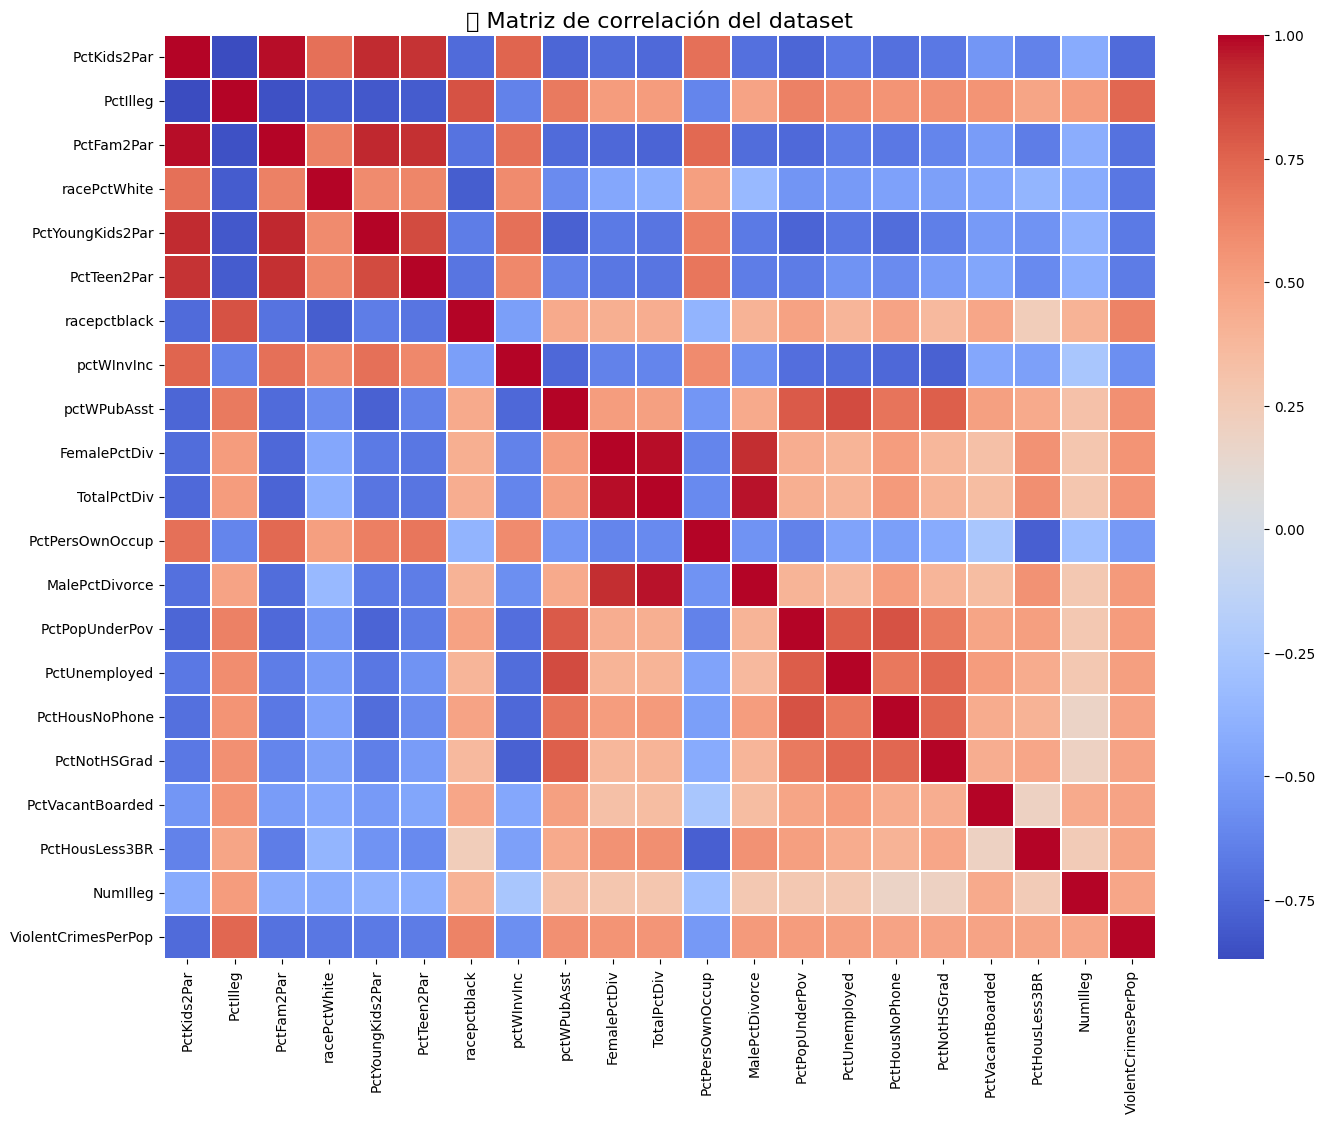

In [216]:
corr = df_model.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.3, annot=False)
plt.title("🔍 Matriz de correlación del dataset", fontsize=16)
plt.show()

In [217]:
target_corr = corr["ViolentCrimesPerPop"].sort_values(ascending=False)

print("🔎 Correlación de cada variable con el target:\n")
print(target_corr)

🔎 Correlación de cada variable con el target:

ViolentCrimesPerPop    1.000000
PctIlleg               0.737965
racepctblack           0.631279
pctWPubAsst            0.574690
FemalePctDiv           0.556472
TotalPctDiv            0.553164
MalePctDivorce         0.525699
PctPopUnderPov         0.521872
PctUnemployed          0.504227
PctHousNoPhone         0.488237
PctNotHSGrad           0.483409
PctVacantBoarded       0.482822
PctHousLess3BR         0.474501
NumIlleg               0.471034
PctPersOwnOccup       -0.525500
pctWInvInc            -0.576329
PctTeen2Par           -0.661598
PctYoungKids2Par      -0.666094
racePctWhite          -0.684787
PctFam2Par            -0.706713
PctKids2Par           -0.738445
Name: ViolentCrimesPerPop, dtype: float64


#### El análisis de correlación permite identificar qué variables están más relacionadas con la criminalidad violenta en una comunidad.
#### Los valores positivos indican que a mayor valor de la variable, mayor criminalidad, mientras que los negativos indican lo contrario:
- Las variables más relacionadas positivamente con el crimen son pobreza, desempleo, precariedad habitacional, baja educación y estructuras familiares inestables.
- Las variables protectoras son las que indican estabilidad económica, estructura familiar sólida y propiedad de vivienda.

In [219]:
model = LinearRegression()

In [221]:
joblib.dump(model, "regressionlineal_model.pkl")
print("Modelo guardado como knn_model.pkl ✔")

Modelo guardado como knn_model.pkl ✔


In [15]:
target = "ViolentCrimesPerPop"

with open("selected_features.txt", "w") as f:
    for col in df_model.columns:
        if col != target:
            f.write(col + "\n")

print("selected_features.txt guardado ✔️ (sin incluir el target)")


selected_features.txt guardado ✔️ (sin incluir el target)


In [223]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [16]:
from sklearn.linear_model import LinearRegression
import joblib

model = LinearRegression()
model.fit(X_train, y_train)

joblib.dump(model, "regressionlineal_model.pkl")
print("Modelo entrenado y guardado ✔️")

Modelo entrenado y guardado ✔️


In [17]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']